Copyright (c) 2019 Primoz Ravbar UCSB Licensed under BSD 2-Clause [see LICENSE for details] Written by Primoz Ravbar

This batch processes ST-images (3C) into ethograms. 

In [13]:
# process ST-images (3C) into ethograms

import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
import pickle
import pandas as pd
import time
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib.colors as mcolors
import natsort
from PIL import Image

from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from ABRS_modules import discrete_radon_transform
from ABRS_modules import etho2ethoAP
from ABRS_modules import smooth_1d
from ABRS_modules import create_LDA_training_dataset
from ABRS_modules import removeZeroLabelsFromTrainingData
from ABRS_modules import computeSpeedFromPosXY 


pathToABRSfolder = 'INSERT PATH TO ABRS MAIN FOLDER HERE'

topInputFolder = 'INSERT PATH TO ST-IMAGES (3C) HERE'

#model = keras.models.load_model('modelConv2ABRS_3C_LiManualLabel_fullTraining_norm256')
#model = keras.models.load_model('modelConv2ABRS_3C')
model = keras.models.load_model('modelConv3C_CS1fb1_fullTraining_norm256_2') #select a model (trained CNN)

model.summary()

ethogramLength = 50000 # number of frames in one movie

outputFolderEtho = pathToABRSfolder + '\\Etho';

storeFrameRec = 0

subfolderList = sorted(os.listdir(topInputFolder))

numbSubfolders = 2

ethoMat = np.zeros((1, ethogramLength))

normalizeByMax = 1
thresholdMovement = 150 # min signal (movement)

for fld in range(0, numbSubfolders, 1):

    inputSubfolderName = subfolderList[fld]
    print (inputSubfolderName)

    inputSubfolderPathName = topInputFolder + '\\' + inputSubfolderName
    
    print (inputSubfolderPathName)
    
    #fileList = natsort.natsorted(os.listdir(inputSubfolderPathName))
    fileList = os.listdir(inputSubfolderPathName)  #sorting files 

    numbFiles = np.shape(fileList)[0]; #1000
    skipFilesNumb =1
    skipFrameNumb =1

    yi = np.zeros((1,10))
    yiVect = np.zeros((1,1))


    if storeFrameRec == 1:
        rtImRec = np.zeros((np.shape(fileList)[0]*50,80,80,3))


    predictionsProbDataRec = np.zeros((10,numbFiles*50))    

    etho = np.zeros((1,numbFiles*50))

    indIm = 0

    for fl in range(0, numbFiles-1, skipFilesNumb): #

        inputFileName = fileList[fl]

        fileDirPathInputName = inputSubfolderPathName + '\\' + inputFileName

        with open(fileDirPathInputName, "rb") as f:
            dict3C = pickle.load(f)

        recIm3C = dict3C["recIm3C"]

        maxMovRec = dict3C['maxMovementRec']


        for i in range(0, recIm3C.shape[0]-1, skipFrameNumb):    

            im3CRaw = recIm3C[i,:,:,:]/1

            if np.count_nonzero(im3CRaw[:,:,0])>5500:            
                im3CRaw[:,:,0] = np.zeros((80,80))

            if np.count_nonzero(im3CRaw[:,:,1])>800:            
                im3CRaw[:,:,1] = np.zeros((80,80))

            rgbArray = np.zeros((80,80,3), 'uint8')
            rgbArray[..., 0] = im3CRaw[:,:,0]
            rgbArray[..., 1] = im3CRaw[:,:,1]
            rgbArray[..., 2] = im3CRaw[:,:,2]
            im3C = Image.fromarray(rgbArray)


            if storeFrameRec == 1:

                rtImRec[indIm,:,:,:] = im3C

            X_rs = np.zeros((1,80,80,3))

            X_rs[0,:,:,:] = im3C

            X = X_rs/256  #normalize image to 0-1

            predictionsProbData = model.predict(X)

            predictionsProbDataRec[:,indIm] = predictionsProbData

            predictionLabelData = np.zeros((1,np.shape(predictionsProbData)[0]))

            etho[0,indIm] = np.argmax(predictionsProbData,axis=1)

            if maxMovRec[i] < thresholdMovement:

                #print('No movement detected')
                etho[0,indIm] = 7 #if no movement is detected call it '7'

            indIm = indIm + 1    
        
    ethoMat = np.vstack((ethoMat,etho)) #each row is an ethogram


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 76, 76, 16)        1216      
_________________________________________________________________
activation_96 (Activation)   (None, 76, 76, 16)        0         
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 34, 34, 16)        6416      
_________________________________________________________________
activation_97 (Activation)   (None, 34, 34, 16)        0         
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 13, 13, 16)        6416      
__________

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


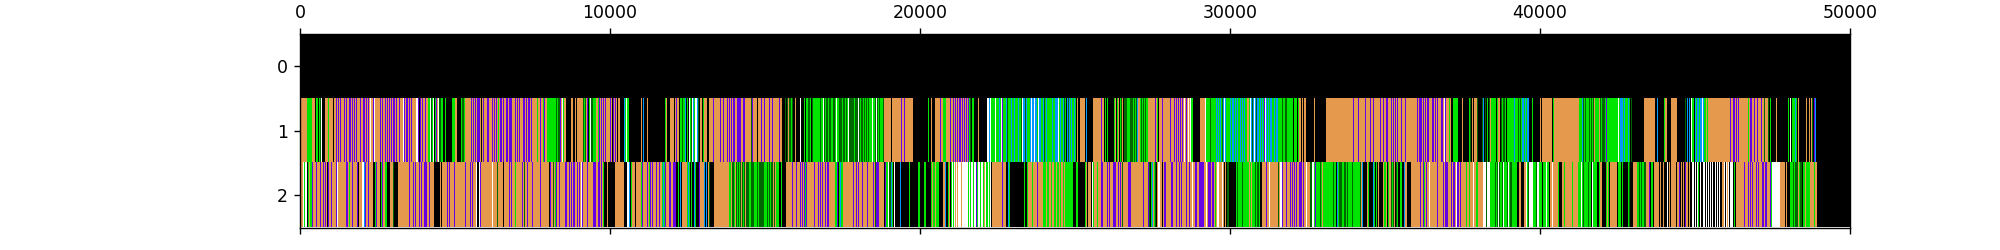

[[7. 6. 6. ... 0. 0. 0.]]


In [11]:
%matplotlib notebook

from ABRS_data_vis import create_colorMat
from ABRS_data_vis import cmapG
from ABRS_data_vis import cmapAP

ethoMat[0,2]=0; ethoMat[0,3]=7

plt.matshow(np.vstack((ethoMat)),interpolation=None, aspect='auto',cmap=cmapG);plt.show()
print(etho)